In [3]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
import matplotlib.pyplot as plt

class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = np.random.normal(0, 0.1, size=(num_visible, num_hidden))
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _gibbs_sampling(self, visible_prob):
        hidden_prob = self._sigmoid(np.dot(visible_prob, self.weights) + self.hidden_bias)

        visible_prob_reconstructed = self._sigmoid(np.dot(hidden_prob, self.weights.T) + self.visible_bias)
       

        return hidden_prob,visible_prob_reconstructed

    def train(self, data, learning_rate=0.1, num_epochs=100, k=1):
        num_samples = data.shape[0]
        reconstruction_errors = []

        for epoch in range(num_epochs):
            np.random.shuffle(data)
            error = 0

            for sample in data:
                visible_prob = sample

                for _ in range(k):
                    hidden_prob,visible_prob= self._gibbs_sampling(visible_prob)

                
                positive_association = np.outer(sample, hidden_prob)
                negative_association = np.outer(visible_prob, self._sigmoid(np.dot(visible_prob, self.weights) + self.hidden_bias))

                self.weights += learning_rate * (positive_association - negative_association)
                self.visible_bias += learning_rate * (sample - visible_prob)
                self.hidden_bias += learning_rate * (hidden_prob - self._sigmoid(np.dot(visible_prob, self.weights) + self.hidden_bias))

                error += np.sum((sample - visible_prob)**2)

            reconstruction_errors.append(error/num_samples)
            print("Epoch %d, Reconstruction Error: %f" % (epoch+1, error/num_samples))

        return reconstruction_errors

    def reconstruct(self, data):
        hidden_prob = self._sigmoid(np.dot(data, self.weights) + self.hidden_bias)
        reconstructed_data = self._sigmoid(np.dot(hidden_prob, self.weights.T) + self.visible_bias)
        return reconstructed_data

    def extract_features(self, data):
        hidden_prob = self._sigmoid(np.dot(data, self.weights) + self.hidden_bias)
        return hidden_prob

class DeepBeliefNetwork:
    def __init__(self, layer_sizes):
        self.rbms = []
        for i in range(len(layer_sizes) - 1):
            rbm = RBM(layer_sizes[i], layer_sizes[i+1])
            self.rbms.append(rbm)

    def pretrain(self, data, learning_rate=0.1, num_epochs=2, k=1):
        input_data = data
        reconstruction_errors = []
        for rbm in self.rbms:
            reconstruction_errors.append(rbm.train(input_data, learning_rate, num_epochs, k))
            input_data = rbm.extract_features(input_data)
        return reconstruction_errors


mnist = fetch_openml("mnist_784")
X = mnist.data / 255.0  
y = mnist.target.astype(int)
X_binarized = binarize(X)
X_train, X_test, y_train, y_test = train_test_split(X_binarized, y, test_size=0.2, random_state=42)

dbn = DeepBeliefNetwork(layer_sizes=[X_train.shape[1], 500, 500])

reconstruction_error = dbn.pretrain(X_train)

c:\Users\PC\.conda\envs\tf\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Epoch 1, Reconstruction Error: 23.172632
Epoch 2, Reconstruction Error: 22.201245
Epoch 1, Reconstruction Error: 1.126239
Epoch 2, Reconstruction Error: 0.414378


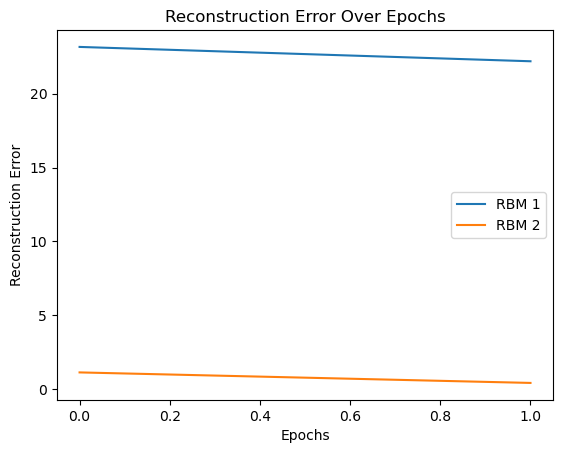

In [6]:

plt.plot(reconstruction_error[0], label='RBM 1')
plt.plot(reconstruction_error[1], label='RBM 2')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Epochs')
plt.legend()
plt.show()

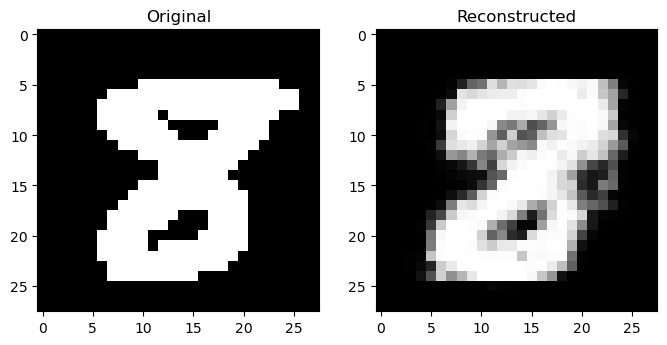

In [7]:
data=X_test
reconstructed_data = dbn.rbms[0].reconstruct(data)

# Plot the original and reconstructed images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(data[0].reshape(28, 28), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plt.imshow(reconstructed_data[0].reshape(28, 28), cmap='gray')
plt.show()


c:\Users\PC\.conda\envs\tf\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


784